# Deep Learning - Project 2 - Convolutional Neural Networks


## Part 1 - Implementation of an image classifier

### 0) Imports

In [1]:
import os
import math
import random
import numpy as np 
import time
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline 
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import sleep
import json

In [2]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("Using torch", torch.__version__)

Using torch 1.12.1


In [3]:
# set seeds for reproducibility
torch.manual_seed(8)
random.seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
torch.cuda.empty_cache()

### 1) Download the data and load it in the Notebook

In [5]:
caltech_data = dset.Caltech101("data", target_type="category", download=True)
categories = caltech_data.categories

Files already downloaded and verified


Number of samples:  8677


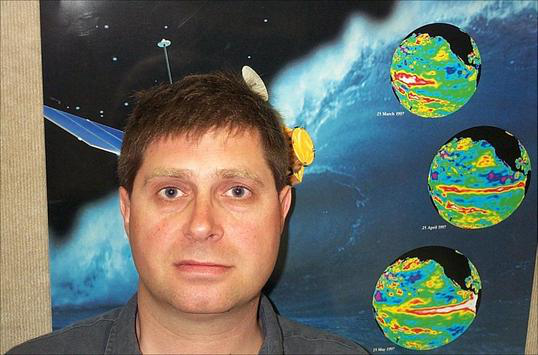

target: Faces, shape: (355, 538, 3)


In [6]:
print('Number of samples: ', len(caltech_data))
img, target = caltech_data[3] # fourth sample
display(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 2) Standardize the images

In [7]:
transform_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x) # unify number of channels
])

caltech_data = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)

Files already downloaded and verified


In [8]:
def mean_std_max_min(loader):
    counter = 0
    ev = torch.empty(3)
    var = torch.empty(3)
    max_val = torch.empty(3)
    min_val = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        number_of_pixels = b * h * w
        # sums over each channel
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        # expected value
        ev = (counter * ev + sum_) / (counter + number_of_pixels)
        # variance
        var = (counter * var + sum_of_square) / (counter + number_of_pixels)
        # update max and min values
        max_values, _ = torch.max(images, dim=2)
        max_values, _ = torch.max(max_values, dim=2)
        max_values, _ = torch.max(max_values, dim=0)
        max_val, _  = torch.max(torch.stack((max_val, max_values)), dim=0)

        min_values, _ = torch.min(images, dim=2)
        min_values, _ = torch.min(min_values, dim=2)
        min_values, _ = torch.min(min_values, dim=0)
        min_val, _  = torch.min(torch.stack((min_val, min_values)), dim=0)
        
        counter += number_of_pixels

    mean, std = ev, torch.sqrt(var - ev ** 2)
    return mean, std, max_val, min_val

In [9]:
BATCH_SIZE = 4
image_data_loader = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std, max_val, min_val  = mean_std_max_min(image_data_loader)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}\nmax = {max_val}\nmin = {min_val}")

Statistics of the whole dataset:
mean = tensor([0.5390, 0.5173, 0.4887])
std = tensor([0.3056, 0.2996, 0.3121])
max = tensor([1., 1., 1.])
min = tensor([-2.6710e-27,  0.0000e+00, -2.6718e-27])


In [10]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html 
transform_standardization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, std)
])

caltech_data = dset.Caltech101("data", transform=transform_standardization, target_type="category", download=True)

Files already downloaded and verified


In [11]:
# CHECK WHETHER mean == 0 and std == 1
image_data_loader_stand = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std, _, _ = mean_std_max_min(image_data_loader_stand)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")
assert torch.le(mean.abs(), 0.001).all(), "Not all of the channels have mean equal to 0"
assert torch.isclose(std, torch.ones_like(std), atol=0.001).all(), "Not all of the channels have standard deviation equal to 1"

Statistics of the whole dataset:
mean = tensor([-4.4689e-07, -1.2186e-08,  8.0951e-07])
std = tensor([1.0000, 1.0000, 1.0000])


In [12]:
def display_img_tensor(img):
    images_np  = img.cpu().numpy()
    img_plt = images_np.transpose(1,2,0)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(np.clip(img_plt, 0, 1))

target: Faces, shape: (3, 256, 256)


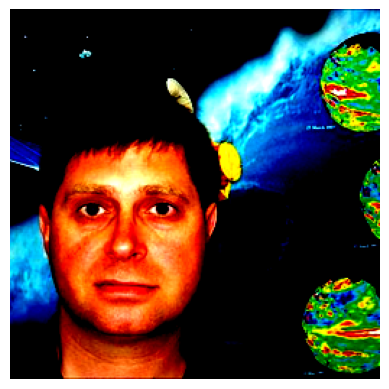

In [13]:
img, target = caltech_data[3]
display_img_tensor(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 3) Divide the collection into Train and Test set

In [14]:
# check the number of samples in each class
classes_count = dict(Counter(caltech_data.y))
classes_count = sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
print("(id, number of samples)")
print(*classes_count[:35])

(id, number of samples)
(5, 800) (3, 798) (0, 435) (1, 435) (94, 239) (2, 200) (12, 128) (19, 123) (55, 114) (23, 107) (47, 100) (46, 99) (13, 98) (16, 91) (50, 88) (63, 87) (54, 86) (86, 86) (92, 86) (15, 85) (39, 85) (90, 85) (81, 84) (75, 82) (57, 81) (51, 80) (58, 78) (65, 76) (35, 75) (93, 75) (26, 73) (27, 70) (25, 69) (34, 68) (31, 67)


In [15]:
# take 20 classes with about 80 examples each
N_CLASSES = 20
chosen_classes = [item[0] for item in classes_count[12:12+N_CLASSES]]
res_list = map(categories.__getitem__, chosen_classes)
print("Selected classes:")
print(*res_list)

Selected classes:
brain butterfly helicopter menorah kangaroo starfish trilobite buddha ewer sunflower scorpion revolver laptop ibis llama minaret electric_guitar umbrella crab crayfish


In [16]:
idx, classes = [], []

for i, cl in enumerate(caltech_data.y):
    if cl in chosen_classes:
        idx.append(i)
        classes.append(cl)

In [17]:
# split
train_indices, test_indices = train_test_split(idx, test_size=0.3, stratify=classes)
len(train_indices), len(test_indices)

(1155, 496)

In [18]:
BATCH_SIZE = 4

train_set = torch.utils.data.Subset(caltech_data, train_indices)
test_set = torch.utils.data.Subset(caltech_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [19]:
def check_sets(loader, show_idx=-1):
    stats_dict = dict()
    i = 0
    for images, labels in loader:
        for  img, lab in zip(images, labels):
          if i == show_idx:
              print('EXEMPLARY IMAGE')
              print(f'Label: {categories[lab]}')
              print(f'Shape: {img.shape}')
              display_img_tensor(img)
          i+=1
          if categories[lab] in stats_dict.keys():
            stats_dict[categories[lab]] += 1
          else:
            stats_dict[categories[lab]] = 1
    return stats_dict

EXEMPLARY IMAGE
Label: revolver
Shape: torch.Size([3, 256, 256])


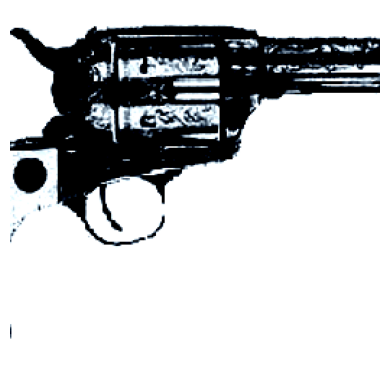

In [20]:
train_stats = check_sets(train_loader, show_idx=10)

EXEMPLARY IMAGE
Label: electric_guitar
Shape: torch.Size([3, 256, 256])


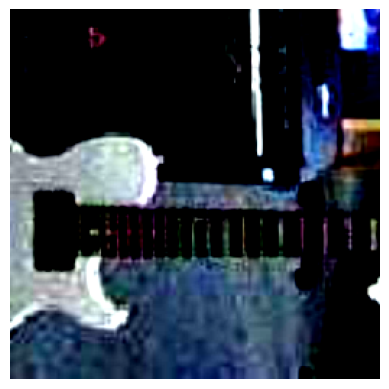

In [21]:
test_stats = check_sets(test_loader, show_idx=10)

In [22]:
assert train_stats.keys() == test_stats.keys()
denom_train = sum(train_stats.values()) # or alternatively len(train_indices)
denom_test = sum(test_stats.values())
print("CHECK CLASS PROPORTIONS IN BOTH SETS:")
for key in train_stats.keys():
    print(f'key: {str.upper(key)}\t\ttrain: {round(train_stats[key]/denom_train*100, 2)}%,\t\ttest: {round(test_stats[key]/denom_test*100,2)}%')

CHECK CLASS PROPORTIONS IN BOTH SETS:
key: ELECTRIC_GUITAR		train: 4.5%,		test: 4.64%
key: CRAYFISH		train: 4.24%,		test: 4.23%
key: EWER		train: 5.11%,		test: 5.24%
key: KANGAROO		train: 5.19%,		test: 5.24%
key: BUDDHA		train: 5.11%,		test: 5.24%
key: LLAMA		train: 4.76%,		test: 4.64%
key: UMBRELLA		train: 4.59%,		test: 4.44%
key: BRAIN		train: 5.97%,		test: 5.85%
key: REVOLVER		train: 4.94%,		test: 5.04%
key: IBIS		train: 4.85%,		test: 4.84%
key: TRILOBITE		train: 5.19%,		test: 5.24%
key: MENORAH		train: 5.28%,		test: 5.24%
key: HELICOPTER		train: 5.37%,		test: 5.24%
key: STARFISH		train: 5.19%,		test: 5.24%
key: LAPTOP		train: 4.94%,		test: 4.84%
key: SUNFLOWER		train: 5.11%,		test: 5.24%
key: MINARET		train: 4.59%,		test: 4.64%
key: SCORPION		train: 5.11%,		test: 5.04%
key: CRAB		train: 4.42%,		test: 4.44%
key: BUTTERFLY		train: 5.54%,		test: 5.44%


In [23]:
# ONE HOT ENCODING
def get_data_one_hot(train_indices, test_indices, caltech_data):
    x = torch.tensor([range(N_CLASSES)])
    one_hot_encoded = F.one_hot(x, num_classes=N_CLASSES)
    one_hot_encoded = torch.squeeze(one_hot_encoded)

    train_label_ids = list({caltech_data.y[i] for i in train_indices}) # list from the set of labels, hence can be either train_indices or test_indices
    temp_dict = dict(list(enumerate(train_label_ids)))
    temp_dict_reversed = dict()
    dict_new_label = dict()
    dict_old_label  = dict()

    for key, value in temp_dict.items():
        one_hot = tuple(one_hot_encoded[key].tolist())
        dict_old_label[one_hot] = value
        dict_new_label[value] = one_hot
        temp_dict_reversed[value] = key

    train_data_one_hot, test_data_one_hot, train_data, test_data = [], [], [], []
    for idx in train_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        train_data_one_hot.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        train_data.append([caltech_data[idx][0],new_label_idx])
    for idx in test_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        test_data_one_hot.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        test_data.append([caltech_data[idx][0],new_label_idx])
        
    return train_data_one_hot, test_data_one_hot, train_data, test_data, (dict_old_label, dict_new_label, temp_dict, temp_dict_reversed)

In [24]:
train_data_one_hot, test_data_one_hot, train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)

In [25]:
def get_label_from_tensor(tensor, dict_old_label, categories):
    key = tensor.tolist()
    if isinstance(key, list):
        key = tuple(key)
    return categories[dict_old_label[key]]

CATEGORY: TRILOBITE
ID: 18
ONE HOT ENCODING: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


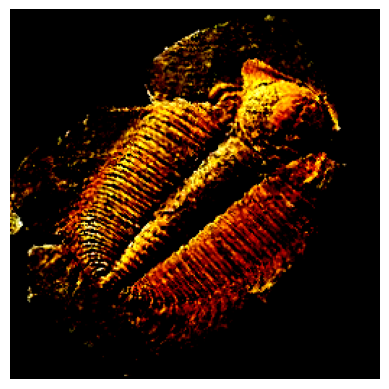

In [26]:
# CHECK TRAIN SET
x = 13
print(f'CATEGORY: {str.upper(get_label_from_tensor(train_data_one_hot[x][1], dicts[0], categories))}')
print(f'ID: {train_data[x][1]}\nONE HOT ENCODING: {train_data_one_hot[x][1]}')
display_img_tensor(train_data_one_hot[x][0])

CATEGORY: SUNFLOWER
ID: 17
ONE HOT ENCODING: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


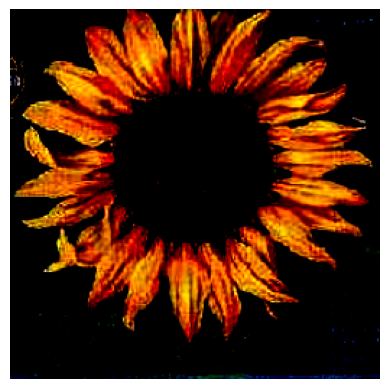

In [27]:
# CHECK TEST SET
x = 30
print(f'CATEGORY: {str.upper(get_label_from_tensor(test_data_one_hot[x][1], dicts[0], categories))}')
print(f'ID: {test_data[x][1]}\nONE HOT ENCODING: {test_data_one_hot[x][1]}')
display_img_tensor(test_data_one_hot[x][0])

### 4) Define the model 

In [28]:
class ConvModel(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(1024*32, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

There is no need to apply softmax in the archictecture, as PyTorch loss function `CrossEntropyLoss` already takes care of that. See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 

In [29]:
# alternative model we tested, unfortunately didn't prevent overfitting 
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(2,2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*8*8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

In [30]:
model = ConvModel(3, N_CLASSES)

# print(f"Model structure: {model}\n\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [32]:
model.to(device)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )


### 5) Train the model

In [33]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [34]:
class EarlyStopper:
    def __init__(self, patience, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_accuracy = -np.inf

    def early_stop(self, test_accuracy):
        if test_accuracy > self.max_accuracy:
            self.max_accuracy = test_accuracy
            self.counter = 0
        elif test_accuracy <= (self.max_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [35]:
def train_model(model, optimizer, train_loader, test_loader, loss_module, epochs=250, batch_size=32, patience=5, verbose=True):
    model.train()
    train_accuracy_epochs = list()
    test_accuracy_epochs = list()
    train_loss_epochs = list()
    test_loss_epochs = list()

    early_stopper = EarlyStopper(patience=patience)
    for epoch in range(epochs):
        train_img_counter = 0
        test_img_counter = 0

        # TRAIN DATA
        model.train()
        mul = 1
        correct = 0
        train_loss = 0.0

        if verbose:
            tepoch = tqdm(train_loader, unit="batch")
        else:
                tepoch = train_loader

        for inputs, labels in tepoch:
            if verbose:
                tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = inputs.to(device), labels.to(device)

            train_img_counter +=inputs.shape[0]
            # print(f'Image counter: {img_counter}')
                
            preds = model(inputs).squeeze(dim=1)
            loss = loss_module(preds, labels)
            train_loss += loss

            pred_labels = torch.zeros(preds.shape)
            _, max_indices = preds.max(dim=1)
            for i in range(preds.size(0)):
                pred_labels[i][max_indices[i]] = 1
                
            pred_labels = pred_labels.to(device)
            correct += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
            train_accuracy = correct / train_img_counter
            mul += 1 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if verbose:
                tepoch.set_postfix(loss=loss.item(), train_accuracy=train_accuracy)
                
        train_accuracy_epochs.append(train_accuracy)
        train_loss_epochs.append((train_loss.cpu()/(mul-1)).item())

        # TEST DATA
        model.eval()
        with torch.no_grad():
            mul = 1
            correct = 0
            test_loss = 0.0

            if verbose:
                ttest = tqdm(test_loader, unit="batch")
            else:
                ttest = test_loader

            for inputs, labels in ttest:
                if verbose:
                    ttest.set_description(f"Test set:")

                inputs, labels = inputs.to(device), labels.to(device)

                test_img_counter +=inputs.shape[0]

                preds = model(inputs).squeeze(dim=1)
                loss = loss_module(preds, labels)
                test_loss += loss

                pred_labels = pred_labels = torch.zeros(preds.shape)
                _, max_indices = preds.max(dim=1)
                for i in range(preds.size(0)):
                        pred_labels[i][max_indices[i]] = 1

                pred_labels = pred_labels.to(device)
                correct += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
                test_accuracy = correct / test_img_counter
                mul += 1 

                if verbose:
                    ttest.set_postfix(loss=loss.item(), test_accuracy=test_accuracy)
            test_accuracy_epochs.append(test_accuracy)
            test_loss_epochs.append((test_loss.cpu()/(mul-1)).item())

            # EARLY STOPPING
            if early_stopper.early_stop(test_accuracy):             
                return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

    return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

In [36]:
EPOCHS = 250
train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5)

Test set:: 100%|██████████| 16/16 [00:00<00:00, 46.26batch/s, loss=1.59, test_accuracy=0.518]


In [37]:
# SAVE TRAINING STATS - will be used later
def save_training_stats(keys, stats, file_path):
    stats_dict = dict([(k,s) for k,s in zip(keys, stats)])
    with open(file_path, 'w') as f:
        json.dump(stats_dict, f)

def load_training_stats(file_path):
    with open(file_path, 'r') as f:
        stats_dict = json.load(f)
    return stats_dict['train_accuracy'], stats_dict['test_accuracy'], stats_dict['train_loss'], stats_dict['test_loss']

In [38]:
keys = ['train_accuracy','test_accuracy','train_loss','test_loss']
stats = (train_accuracy,test_accuracy,train_loss,test_loss)
save_training_stats(keys, stats, 'stats/training_stats.json')

#### Model analysis

Learning curves

In [39]:
def visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(17,7)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    x = range(1, len(train_loss)+1)
    # ACCURACY
    ax1.plot(x, train_accuracy, label='train accuracy')
    ax1.plot(x, test_accuracy, label='test accuracy')
    ax1.set(xlabel='Epoch', xticks=range(1, len(train_loss)+1, 5), title='Accuracy learning curves')
    ax1.legend()
    # LOSS FUNCTION
    ax2.plot(x, train_loss, label='train loss')
    ax2.plot(x, test_loss, label='test loss')
    ax2.set(xlabel='Epoch', xticks=range(1, len(train_loss)+1, 5), title='Loss function learning curves')
    ax2.legend()
    plt.show()

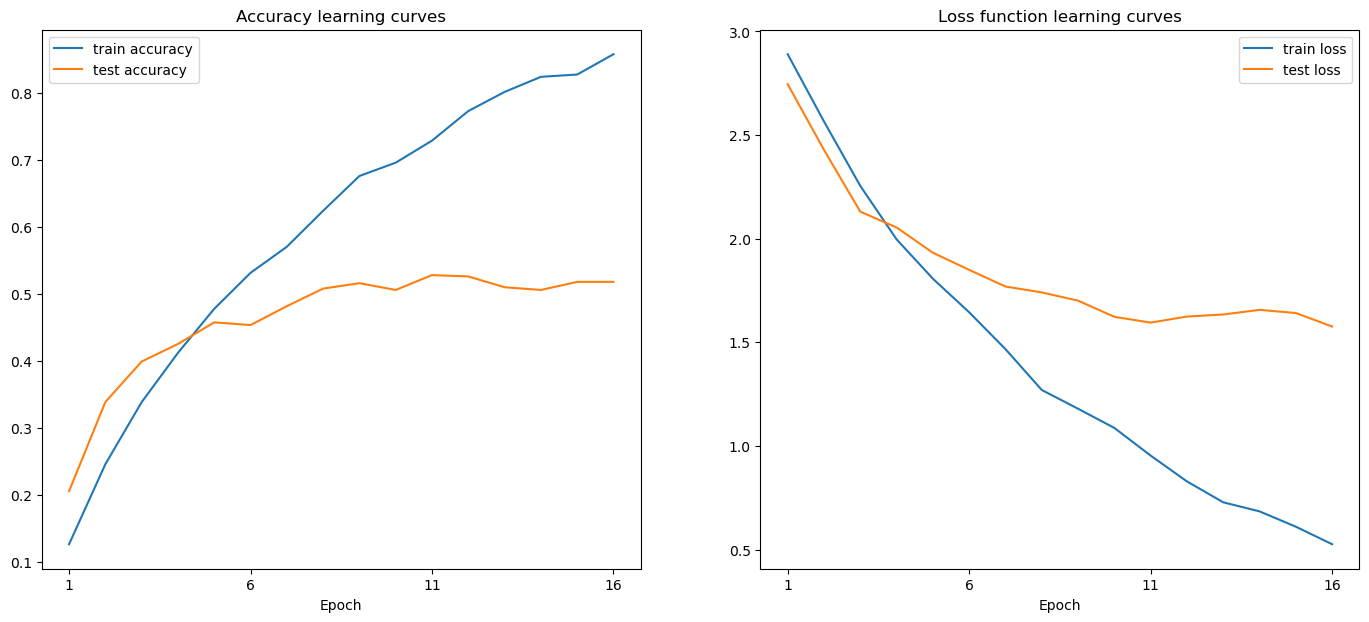

In [40]:
visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss)

Confusion matrix for test data

In [41]:
def evaluate_model(model, data_loader, dict_old_label, categories):
    y_pred = []
    y_true = []
    model.eval()
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs).squeeze(dim=1)

            pred_labels = torch.zeros(preds.shape)
            _, max_indices = preds.max(dim=1)
            for i in range(preds.size(0)):
                pred_labels[i][max_indices[i]] = 1
            
            # pred_labels = pred_labels.to(device)
            for pred, true in zip(max_indices, labels):
                y_pred.append(get_label_from_tensor(pred, dict_old_label, categories))
                y_true.append(get_label_from_tensor(true, dict_old_label, categories))
            
            # true_preds += torch.sum((pred_labels == labels)*(pred_labels == 1)).item()
            true_preds += sum([1 for tensor, pos in zip(pred_labels, labels) if tensor[pos.item()].item() == 1])
            num_preds += labels.shape[0]

    print(f'Accuracy of the model: {100.0*(true_preds/num_preds):4.2f}%')
    return y_pred, y_true

In [42]:
def get_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=list(set(y_true)))
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical')
    disp.ax_.set(xlabel='Predicted', ylabel='True')
    ax.set_title('Confusion matrix', fontsize=20)
    plt.show()

Accuracy of the model: 51.81%


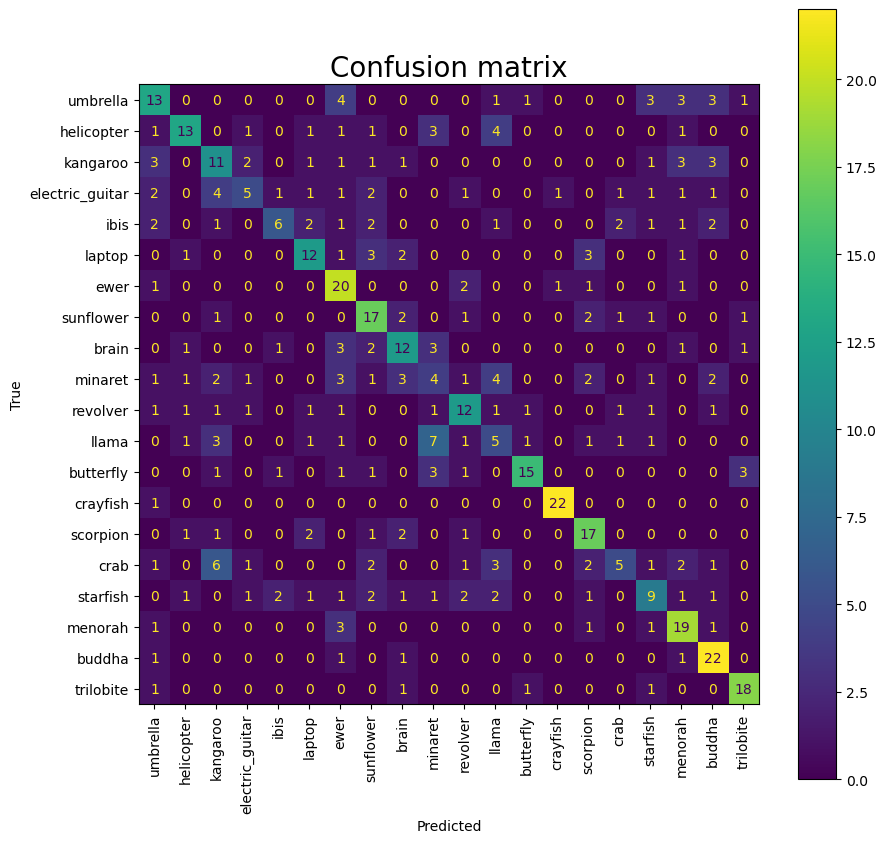

In [43]:
dict_old_label = dicts[2]
y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
get_confusion_matrix(y_true, y_pred)

Precision and recall for each class

In [44]:
def precision_recall_classes(y_true, y_pred, verbose=True):
    labels_set = list(set(y_true))
    starting_dict = {'TP':0, 'FP':0, 'FN':0}
    temp = dict([(label,starting_dict.copy()) for label in labels_set])

    for pred, true in zip(y_pred, y_true):
        if pred == true:
            temp[pred]['TP'] += 1
        else:
            temp[true]['FN'] += 1
            temp[pred]['FP'] += 1
    stats = dict()
    for key, summary in temp.items():
        if (summary['TP']+summary['FP']) != 0:
            precision = summary['TP']/(summary['TP']+summary['FP'])
        else:
            precision = 0
        if (summary['TP']+summary['FN']) != 0:
            recall = summary['TP']/(summary['TP']+summary['FN'])
        else:
            recall = 0
        stats[key] = {'precision':precision, 'recall':recall}
        if verbose: 
            print(f'LABEL: {str.upper(key)}     \t\tprecision: {precision*100:3.2f}%, recall: {recall*100:3.2f}%')
    return stats


In [45]:
stats = precision_recall_classes(y_true, y_pred)

LABEL: UMBRELLA     		precision: 75.00%, recall: 81.82%
LABEL: HELICOPTER     		precision: 48.57%, recall: 65.38%
LABEL: KANGAROO     		precision: 18.18%, recall: 15.38%
LABEL: ELECTRIC_GUITAR     		precision: 54.55%, recall: 52.17%
LABEL: IBIS     		precision: 48.00%, recall: 50.00%
LABEL: LAPTOP     		precision: 52.17%, recall: 50.00%
LABEL: EWER     		precision: 46.51%, recall: 76.92%
LABEL: SUNFLOWER     		precision: 54.29%, recall: 73.08%
LABEL: BRAIN     		precision: 44.83%, recall: 44.83%
LABEL: MINARET     		precision: 91.67%, recall: 95.65%
LABEL: REVOLVER     		precision: 56.67%, recall: 68.00%
LABEL: LLAMA     		precision: 23.81%, recall: 21.74%
LABEL: BUTTERFLY     		precision: 35.48%, recall: 40.74%
LABEL: CRAYFISH     		precision: 54.55%, recall: 28.57%
LABEL: SCORPION     		precision: 45.45%, recall: 20.00%
LABEL: CRAB     		precision: 41.67%, recall: 22.73%
LABEL: STARFISH     		precision: 40.91%, recall: 34.62%
LABEL: MENORAH     		precision: 78.95%, recall: 57.69%
LAB

Exemplary predictions

In [46]:
def show_prediction(model, data, dict_tensor, dict_old_label, categories):
    input, label = data[0], data[1]
    model.eval()
    input = input[None, :]
    input = input.to(device)
    pred = model(input)
    pred = pred.squeeze(dim=0)
    print('PROBABILITIES:')
    print(pred.cpu().detach().numpy())
    
    pred_label = torch.zeros(pred.shape)
    _, max_idx = pred.max(dim=0)
    pred_label[max_idx] = 1
    pred_label = pred_label.squeeze(dim=0)

    print('\nPREDICTION:')
    print(f'{pred_label.cpu().detach().numpy()} -> {get_label_from_tensor(pred_label, dict_tensor, categories)}')
    print(f'TRUE CLASS: {categories[dict_old_label[label]]}')
    display_img_tensor(input[0])

PROBABILITIES:
[ 0.38700205 -1.0659769   0.9746128   1.0618422  -0.9186692   1.382487
 -1.6052612  -1.1130611  -1.7405033  -0.22356853 -2.4165275  -0.92471045
 -0.91229534  0.26265216 -5.0053277  -0.15625131 -2.2533305   4.6093817
  2.4150815  -0.77833164]

PREDICTION:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] -> sunflower
TRUE CLASS: sunflower


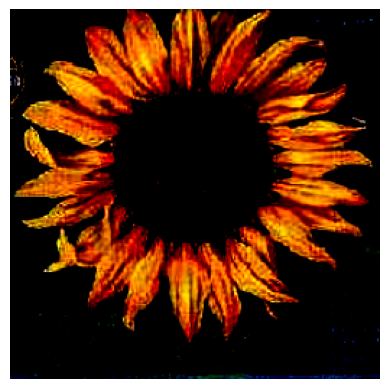

In [47]:
# TODO - make sure it's correctly/incorrecly classified!
dict_old_lbl = dicts[0]
dict_tensor= dicts[2]

# CLASSIFIED CORRECTLY
x = 30
show_prediction(model, test_data[x], dict_old_lbl, dict_tensor, categories)

PROBABILITIES:
[-1.2123501  -0.45744827  4.17664    -1.4859535   4.487805   -2.534358
  2.971063    3.500401   -0.5055138  -0.6143418  -1.0815383  -3.9990976
 -0.04698309 -1.6265948  -1.4779515   3.5735705   3.2857323   2.6116462
  0.01117773 -1.1186624 ]

PREDICTION:
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> crayfish
TRUE CLASS: starfish


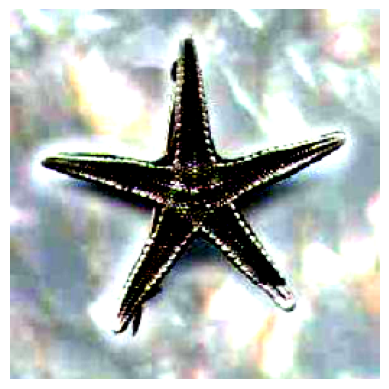

In [48]:
# CLASSIFIED INCORRECTLY
x = 20
show_prediction(model, test_data[x], dict_old_lbl, dict_tensor, categories)

### 6) Save the model to disk

In [49]:
# in Keras: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_object, path):
    if not torch.cuda.is_available():
        return model_object.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    return model_object.load_state_dict(torch.load(path))

In [51]:
save_model(model, 'model/model.pth')
new_model = ConvModel(3, N_CLASSES)
load_model(new_model, 'model/model.pth')
new_model.to(device)

ConvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.5, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )


Check whether it works properly

Accuracy of the model: 51.81%


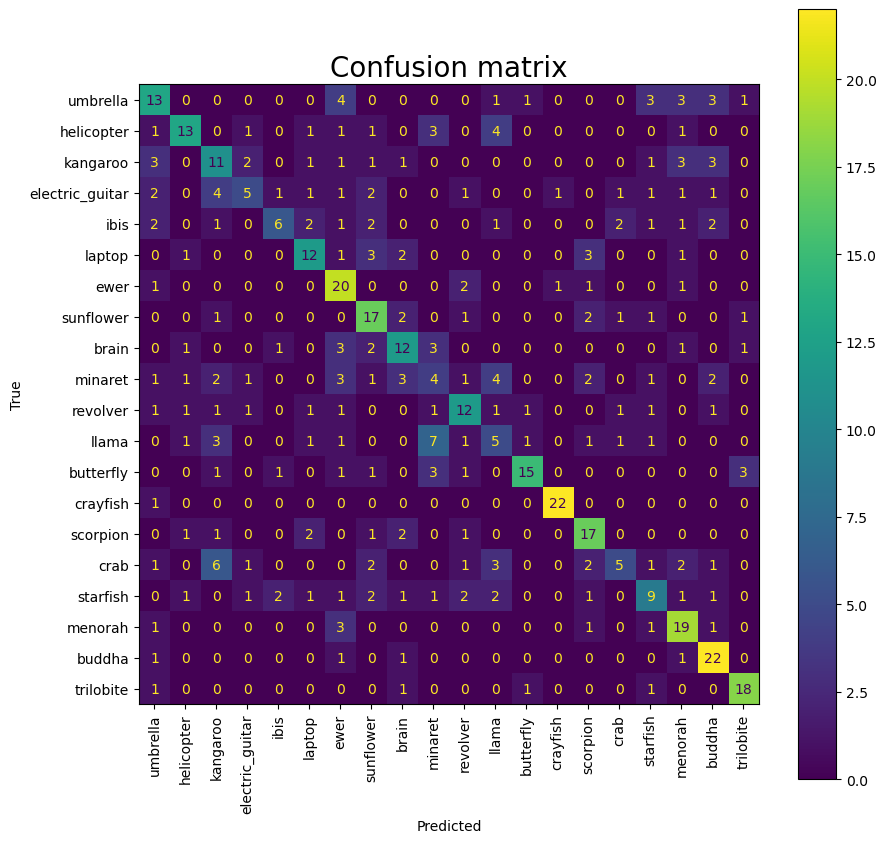

In [52]:
y_pred, y_true = evaluate_model(new_model, test_loader, dict_old_label, categories)
get_confusion_matrix(y_true, y_pred)

### 7) Summary of the Part 1 - describe your observations

#### Working with PyTorch
The major modification we applied was doing the project in PyTorch instead of Keras, hence some steps along the way needed to be slightly changed in order to meet the criteria for the pipeline to work.<br>
Caltech101 dataset is already available in `torchvision.datasets` module, making it very convenient to work with. Since one-hot encoding is not necessary while building a classifier and using cross entropy loss in PyTorch, passing class index targets worked as expected (it needed to be modified to be in the range [0, N-1] though, where N is the number of classes; we still changed labels to one-hot encoding in order to not skip the requirement - more like a proof of concept :))

#### Model and results
Initially, we created a model based on the suggestions provided in the description. The results might have been better, therefore we experimented with the hyperparameters and the architecture of the network itself (e.g. adding/removing convolutional blocks, trying different different learning/dropout rates etc.). Finally, we obtained a model having the accuracy value of `51%`. Unfortunately, despite tweaking the parameters, we can clearly see the overfitting on the plots. For this particular case we firstly added regularizations and made changes in the dropout rate paremeter, also we decreased the number of convolutional layers/channels in them; however, the accuracy was even poorer then.<br><br>
Some of the classes turned out to be troublesome - our model finds it difficult to classify *sunflowers*, *minarets* and *ibises* correctly. On the other hand, it performed well on the images of *umbrellas*, *crayfish* and *llamas*. The interesting observation is that *menorah* classed often was classified as *minaret* but also as *crayfish* - the confusing part might be the presence of arcs in the pictures. Lots of animals such as *crab*, *butterfly*, *starfish*, *brain* (treat it as a part of animal :)) were classified as *trilobite* - it might be due to the fact that the thorax of trillobite is quite generic, therefore might be treated as a part of another animal (poor precision but note that the class itself has been nicelly recalled).<br><br>
Last but not least, as for the opportunities for the model to improve might include augmenting the dataset, adding more convolutional blocks combined with fine-tuning the hyperparameters further.

## Part 2 - Experimental comparative analysis

### TASK 3: Compare the models without and with Dropout with different rates (e.g. 0.1, 0.2, 0.5)

Dropout rate = 0
Training time = 35.88s
Accuracy of the model: 58.87%


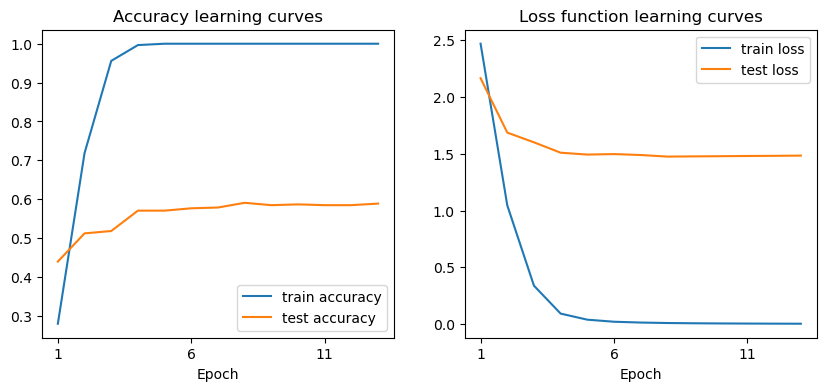

-------------------------------------------------------------
Dropout rate = 0.1
Training time = 58.80s
Accuracy of the model: 58.06%


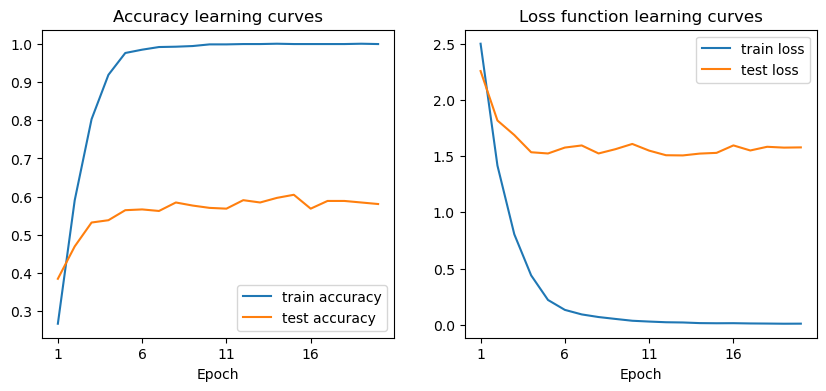

-------------------------------------------------------------
Dropout rate = 0.2
Training time = 50.06s
Accuracy of the model: 58.06%


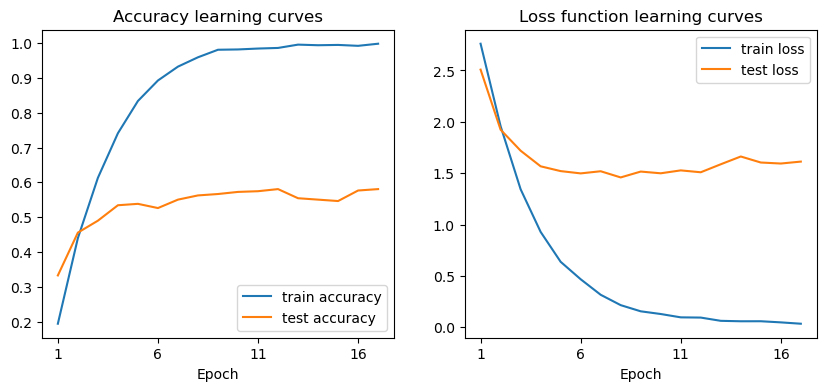

-------------------------------------------------------------
Dropout rate = 0.5
Training time = 56.00s
Accuracy of the model: 50.81%


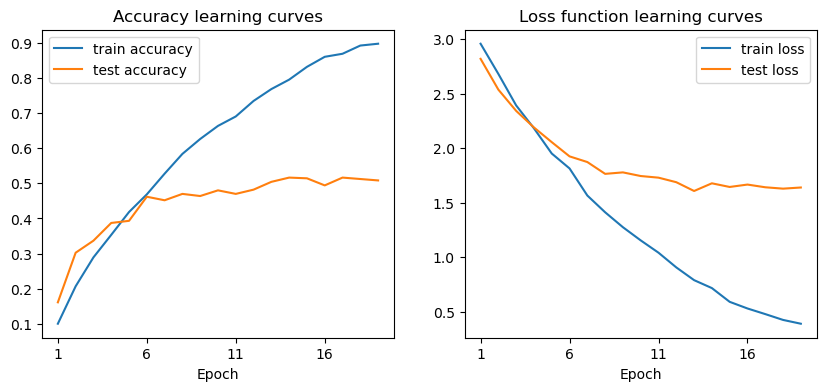

-------------------------------------------------------------
Dropout rate = 0.7
Training time = 88.39s
Accuracy of the model: 42.14%


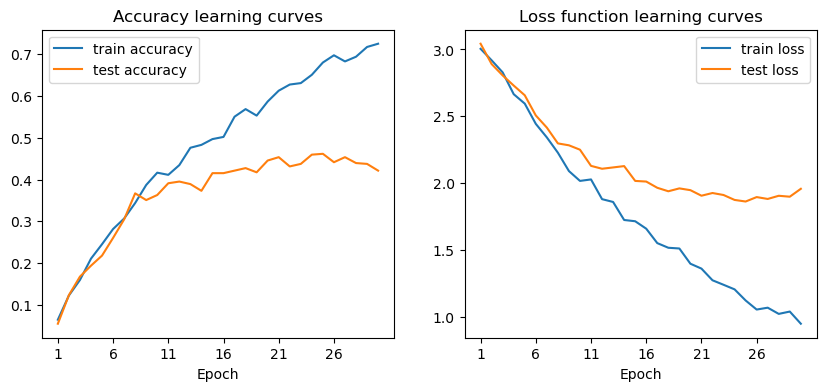

-------------------------------------------------------------


In [53]:
dropout_rates = [0, 0.1, 0.2, 0.5, 0.7]

for p in dropout_rates:
    print(f"Dropout rate = {p}")
    model = ConvModel(3, N_CLASSES, dropout_rate=p)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")
    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
Along with increasing dropout rate, accuracy decreases. However, with higher dropout rates, overfitting is smaller. The time of training is similar for every experiment.

Dropout rate = 0.5 seems to be the best choice, as it is compromise between highest accuracy and smallest overfitting.

### TASK 6: Compare the models for different preprocessing approaches <br>(perform operations separately per channel):
- Raw data - $X$
- Subtracting the mean ($X - \mu$)
- Normalization ($\frac{X - min}{max - min}$)
- Standardization ($\frac{X - \mu}{\sigma}$)

In [54]:
def evaluate_on_data(caltech_data, train_indices, test_indices, epochs=EPOCHS):
    _, _, train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

    model = ConvModel(3, N_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=epochs, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")

    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

RAW DATA:
Files already downloaded and verified
Training time = 93.09s
Accuracy of the model: 54.23%


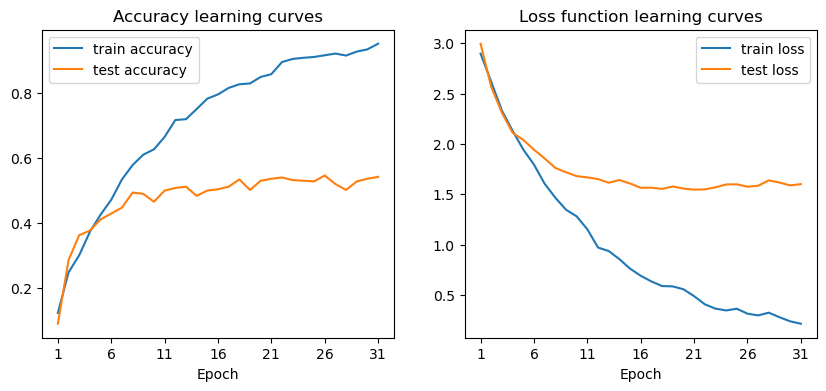

-------------------------------------------------------------
MEAN SUBSTRACTED:
Files already downloaded and verified
Training time = 65.55s
Accuracy of the model: 52.62%


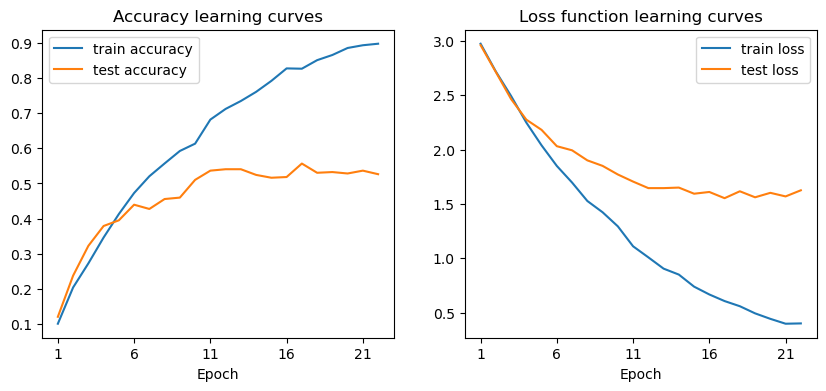

-------------------------------------------------------------
NORMALIZATION:
Files already downloaded and verified
Training time = 65.65s
Accuracy of the model: 55.65%


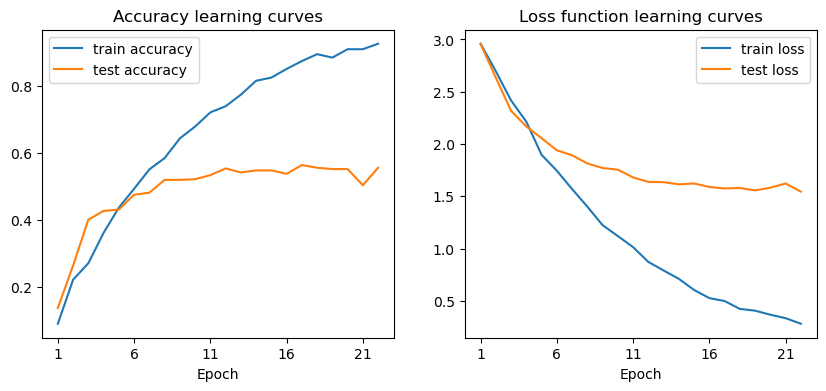

-------------------------------------------------------------
STANDARIZATION:
Accuracy of the model: 51.81%


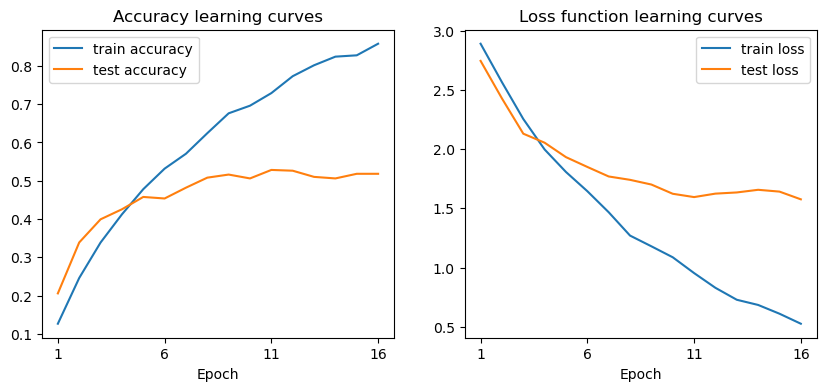

-------------------------------------------------------------


In [55]:
# RAW DATA (images are just cropped)
print("RAW DATA:")
caltech_data_raw = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)
evaluate_on_data(caltech_data_raw, train_indices, test_indices)

# MEAN SUBSTRACTED
# mean -> calculated earlier
print("MEAN SUBSTRACTED:")
transform_mean = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, torch.ones(3))
])
caltech_data_mean = dset.Caltech101("data", transform=transform_mean, target_type="category", download=True)
evaluate_on_data(caltech_data_mean, train_indices, test_indices)

# NORMALIZATION
# max_val, min_val -> calculated earlier (the variables are used, although it is known the range is [0, 1])
print("NORMALIZATION:")
transform_norm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(min_val, (max_val- min_val))
])
caltech_data_norm = dset.Caltech101("data", transform=transform_norm, target_type="category", download=True)
evaluate_on_data(caltech_data_norm, train_indices, test_indices)

# STANDARIZATION (i.e. the main approach, therefore the model as well as the stats calculated during training are loaded from files)
print("STANDARIZATION:")
target_model = ConvModel(3, N_CLASSES)
load_model(target_model, 'model/model.pth')
target_model.to(device)
y_pred, y_true = evaluate_model(target_model, test_loader, dict_old_label, categories)
train_accuracy, test_accuracy, train_loss, test_loss = load_training_stats('stats/training_stats.json')
visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
print("-------------------------------------------------------------")

#### Conclusions
Taking raw, cropped images turned out to have similar outcome as centerting the values around the origin, i.e. substracting the mean. Normalization and standarization approaches gave a bit better results, although thay did not differ much in terms of the quality of the predictions, therefore one may conclude that min-max normalization, and hence, giving equal weights to all channels would not signifinantly influence the performence of the model compared to the standarization approach (i.e. weighting features differently based on how much they vary).

### TASK 9: Compare the models with different number of Convolutional blocks

In [58]:
class ConvModel4(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv4 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(16384, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvModel3(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(1024*32, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvModel2(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(131072, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ConvModel1(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes, dropout_rate=0.5):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(p=dropout_rate),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(262144, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Model with 1 convolutional blocks
Training time = 100.98s
Accuracy of the model: 44.56%


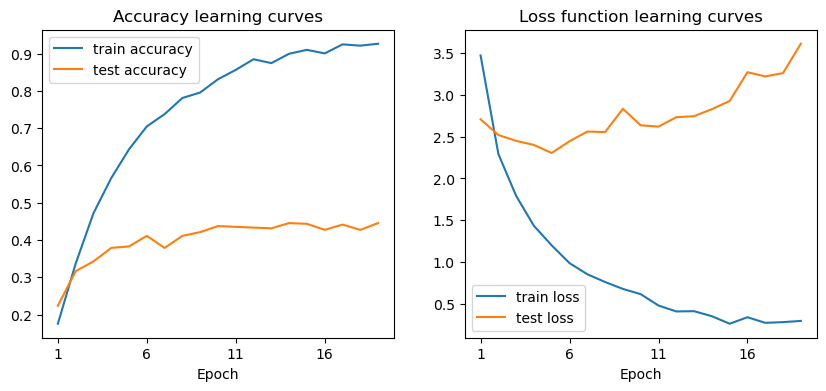

-------------------------------------------------------------
Model with 2 convolutional blocks
Training time = 83.67s
Accuracy of the model: 51.61%


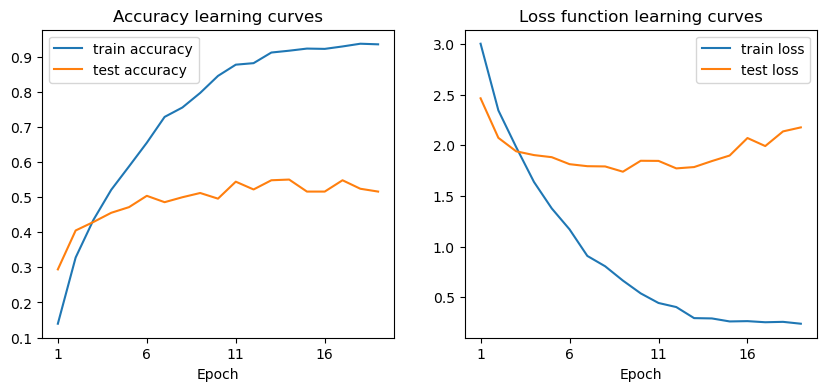

-------------------------------------------------------------
Model with 3 convolutional blocks
Training time = 61.81s
Accuracy of the model: 51.01%


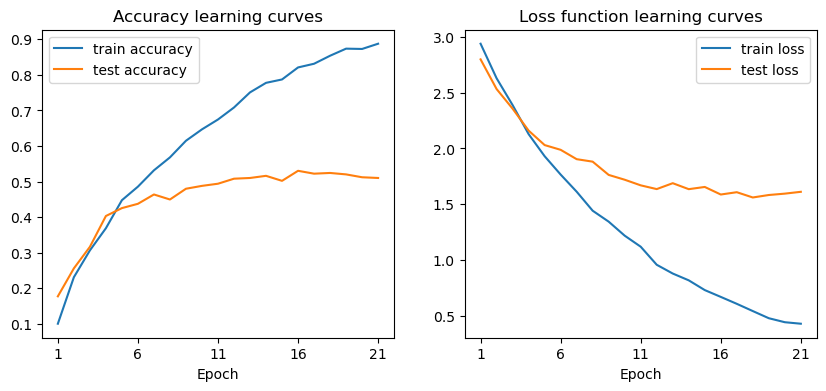

-------------------------------------------------------------
Model with 4 convolutional blocks
Training time = 102.55s
Accuracy of the model: 55.85%


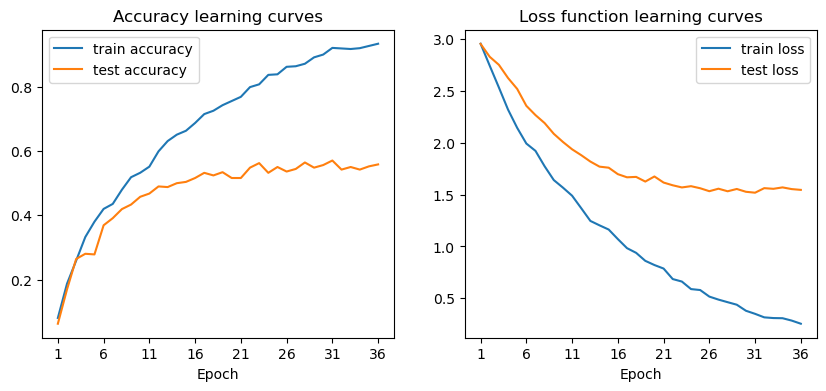

-------------------------------------------------------------


In [59]:
models = [ConvModel1(3, N_CLASSES), ConvModel2(3, N_CLASSES), ConvModel3(3, N_CLASSES), ConvModel4(3, N_CLASSES)]

for i, model in enumerate(models):
    print(f"Model with {i+1} convolutional blocks")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")
    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
Using just one block causes terrible overfit. Our initial thought was that reducing complexity of a model will help with overfitting, but it worsened the results. The experiment showed, that adding more blocks slightly improved accuracy and reduced the overfitting.

### TASK 11: Training with different batch sizes (e.g. 1, 16, 32, number_of_samples)

BATCH SIZE: 1
Training time = 483.53s
Accuracy of the model: 45.77%


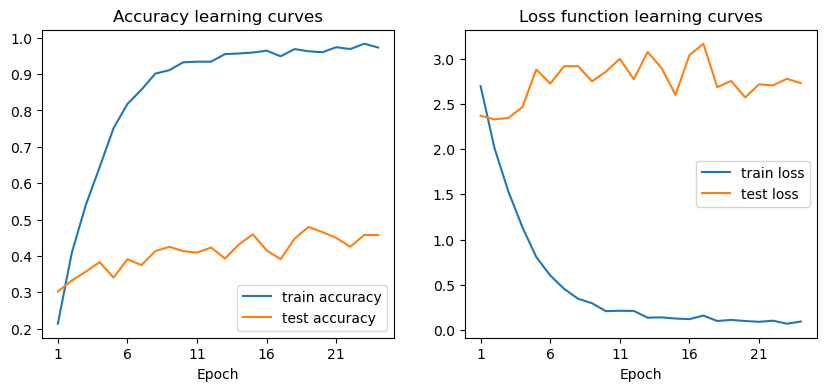

-------------------------------------------------------------
BATCH SIZE: 16
Training time = 56.03s
Accuracy of the model: 53.23%


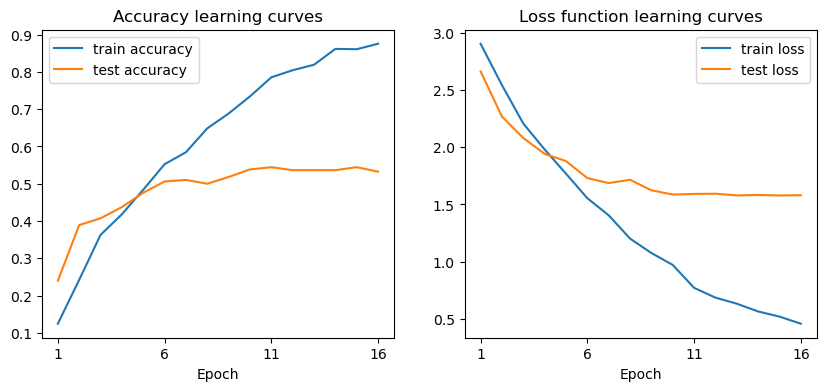

-------------------------------------------------------------
BATCH SIZE: 32
Training time = 71.64s
Accuracy of the model: 50.40%


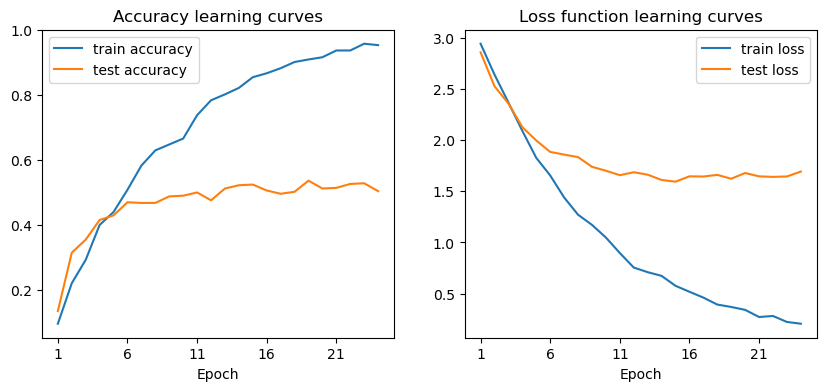

-------------------------------------------------------------
BATCH SIZE: 128
Training time = 86.71s
Accuracy of the model: 52.02%


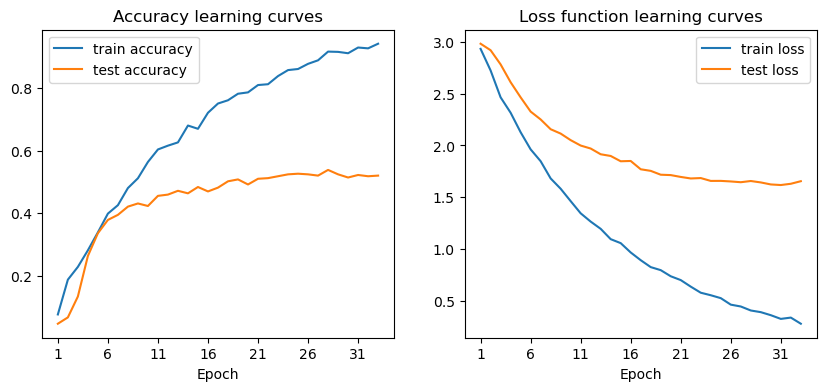

-------------------------------------------------------------


In [60]:
BATCH_SIZES = [1, 16, 32, 128]

for b in BATCH_SIZES:
    print(f'BATCH SIZE: {b}')
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=b)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=b)

    model = ConvModel(3, N_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    model.to(device)

    training_start_time = time.time()
    train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS, batch_size=b, patience=5, verbose=False)
    print(f"Training time = {time.time() - training_start_time:.2f}s")

    y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)
    visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss, figsize=(10, 4))
    print("-------------------------------------------------------------")

#### Conclusions
Setting the batch size to 1 lead to slower training, however it did not make the model more robust to noise in the data. Instead, terrible overfitting is visible on the plot. In fact, the occurrence of overfitting is visible in every plot, with the fastest convergence in the case of the batch being set to 128.